# SleepInsight AI - Model Training & EDA

This notebook documents the exploratory data analysis and model training process for the SleepInsight AI project using the unified training dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Load Data

We load the processed training data which combines features from multiple sources.

In [2]:
df = pd.read_csv('../data/processed_training_data.csv')
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset: 100 rows, 9 columns


,age,gender,sleep_duration_hr,heart_rate,stress_level,rem_percent,deep_percent,awakenings,sleep_score
0,56,Male,7.082550,64.658751,9.236924,23.305546,17.205551,3,52.108381
1,69,Male,9.416401,79.766821,4.981170,18.190918,24.779291,0,100.000000
2,46,Male,6.621725,78.837597,3.158086,29.192918,15.651085,7,32.533827
3,32,Male,5.610440,62.322432,1.844860,26.719441,21.243674,0,61.909038
4,60,Male,6.781489,71.701609,2.645794,16.701969,15.894842,2,49.004717


## 2. Exploratory Data Analysis (EDA)

Visualizing the relationships between features and the target `sleep_score`.

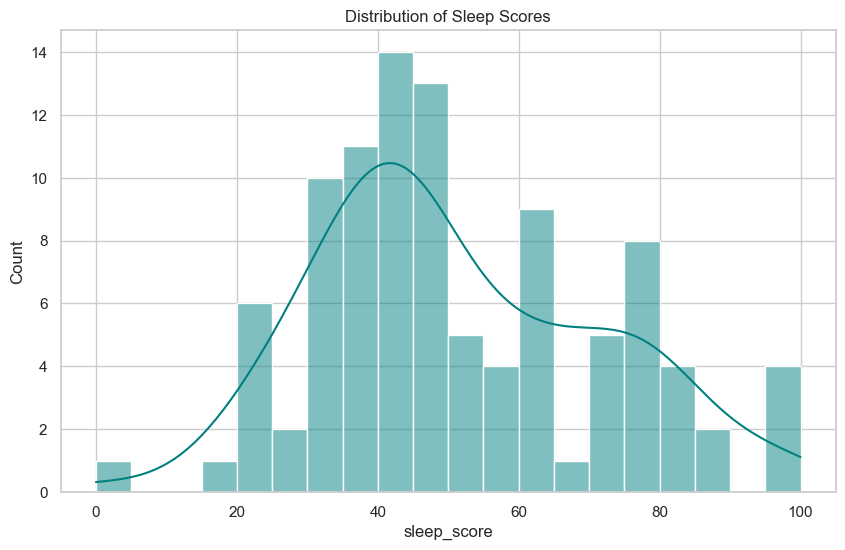

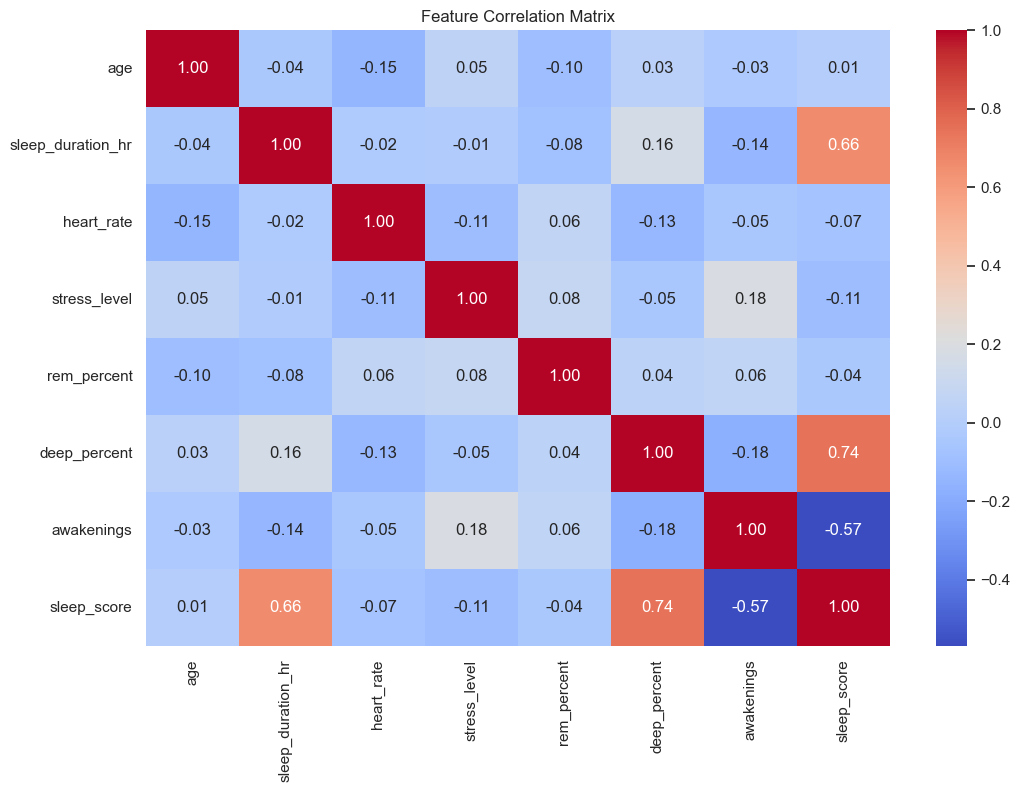

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sleep_score'], bins=20, kde=True, color='teal')
plt.title('Distribution of Sleep Scores')
plt.show()

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

## 3. Model Training

We use a `RandomForestRegressor` within a scikit-learn pipeline for robust preprocessing and prediction.

In [4]:
X = df.drop('sleep_score', axis=1)
y = df['sleep_score']

numeric_features = ['age', 'sleep_duration_hr', 'heart_rate', 'stress_level', 'rem_percent', 'deep_percent', 'awakenings']
categorical_features = ['gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

print("Training model...")
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Training model...
Mean Absolute Error: 4.91
R2 Score: 0.89


## 4. Feature Importance

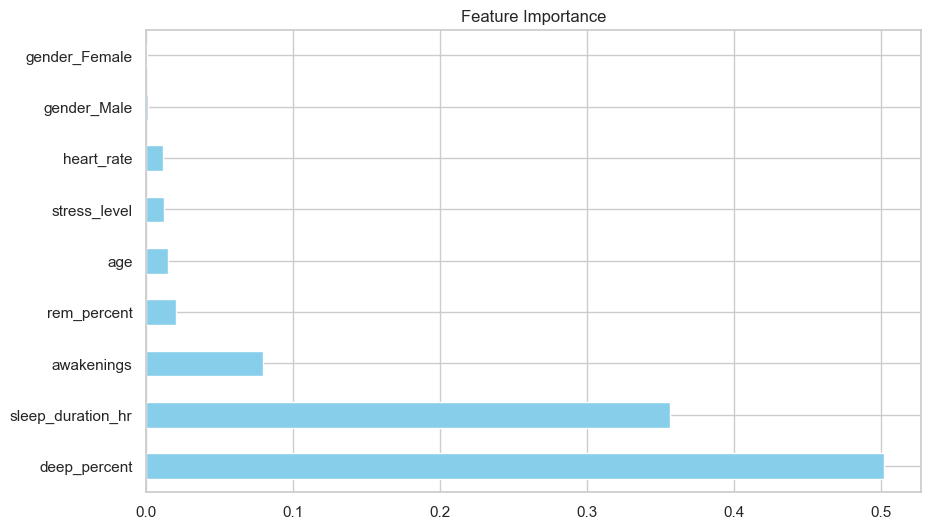

In [5]:
importances = model_pipeline.named_steps['regressor'].feature_importances_
feature_names = numeric_features + list(model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.show()

In [6]:
# Save model for deployment
joblib.dump(model_pipeline, 'sleep_model_pipeline.pkl')
print("Model artifact updated at models/sleep_model_pipeline.pkl")

Model artifact updated at models/sleep_model_pipeline.pkl
